In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorboard
from datetime import datetime

# Restrict GPU memory consumption
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# Configure tensorboard
logdir = "U:/Coding/~Learning/Pd/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [3]:
# load in the data
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
type(data)

sklearn.utils.Bunch

** note: ** it is a Bunch object. This basically acts like a dictionary where you can treat the keys like attributes

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
# 'data' (the attributes) means the input data
data.data.shape
# it has 569 samples, 30 features

(569, 30)

In [6]:
# 'targets'
data.target, data.target.shape
# note how the targets are just 0s and 1s
# normally, when you have K targets, they are labeled 0..K-1


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [7]:
# they meaning is not lost
data.target_names, data.feature_names

(array(['malignant', 'benign'], dtype='<U9'),
 array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symmetry', 'worst fractal dimension'], dtype='<U23'))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
N, D = X_train.shape
N, D

(381, 30)

In [9]:
# Scale the data (normalize)
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# learning rate scheduler
def schedule(epoch, lr):
    if epoch >= 50:
        return 0.001
    return 0.01

scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [11]:
# Now all the TF stuff - build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(D,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Alternatively, you can do:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Dense(1, input_shape=(D,), activation='sigmoid'))

model.compile(optimizer='adam',
                loss = 'binary_crossentropy',
                metrics=['accuracy'])

# Train the model
training_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, callbacks=[tensorboard_callback, scheduler])

# Evaluate the model - evaluate() returns loss and accuracy
print("Train score: ", model.evaluate(X_train, y_train))
print("Test score: ", model.evaluate(X_test, y_test))

2 [==============================] - 0s 5ms/step - loss: 0.0658 - accuracy: 0.9790 - val_loss: 0.0778 - val_accuracy: 0.9681
Epoch 364/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0390 - accuracy: 0.9890 - val_loss: 0.0777 - val_accuracy: 0.9681
Epoch 365/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0502 - accuracy: 0.9887 - val_loss: 0.0777 - val_accuracy: 0.9681
Epoch 366/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0337 - accuracy: 0.9933 - val_loss: 0.0775 - val_accuracy: 0.9681
Epoch 367/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0637 - accuracy: 0.9842 - val_loss: 0.0779 - val_accuracy: 0.9681
Epoch 368/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0578 - accuracy: 0.9870 - val_loss: 0.0782 - val_accuracy: 0.9681
Epoch 369/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0368 - accuracy: 0.9944 - val_loss: 0.0774 - val_accuracy: 0.9681
Epoch 370/500
12/

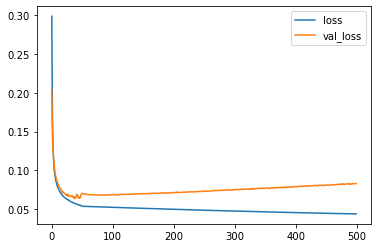

In [12]:
# Plot what's returned by model.fit()
plt.plot(training_history.history['loss'], label='loss')
plt.plot(training_history.history['val_loss'], label='val_loss')
plt.legend()

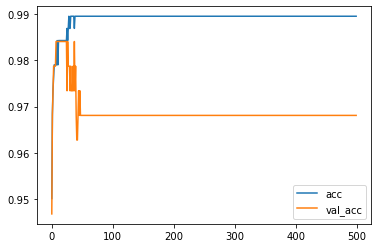

In [13]:
# Plot the accuracy too
plt.plot(training_history.history['accuracy'], label='acc')
plt.plot(training_history.history['val_accuracy'], label='val_acc')
plt.legend()

# Making Predictions

In [14]:
P = model.predict(X_test)
print(P) # they are outputs of the sigmoid, interpreted as probabilities p(y = 1 | x)

[[3.38523462e-02]
 [7.25661891e-07]
 [9.99343932e-01]
 [9.99062359e-01]
 [8.69389344e-03]
 [9.83208239e-01]
 [8.90832603e-01]
 [9.99370396e-01]
 [9.99793708e-01]
 [9.99732792e-01]
 [9.99975443e-01]
 [9.92733598e-01]
 [4.40984756e-01]
 [9.99952555e-01]
 [2.61616748e-04]
 [9.99841213e-01]
 [9.79695797e-01]
 [9.89099264e-01]
 [9.99988317e-01]
 [9.99654531e-01]
 [9.99977589e-01]
 [3.83441161e-17]
 [9.96755898e-01]
 [7.70280778e-01]
 [9.99951363e-01]
 [6.48661866e-04]
 [9.89459634e-01]
 [5.82532156e-12]
 [9.99071479e-01]
 [3.20975573e-07]
 [9.99810278e-01]
 [8.28927040e-01]
 [1.52820878e-09]
 [2.21269119e-07]
 [1.00000000e+00]
 [1.21605257e-03]
 [9.99970555e-01]
 [7.60006011e-01]
 [2.61083227e-02]
 [1.78303733e-01]
 [1.54966074e-05]
 [9.49522147e-17]
 [3.12271259e-05]
 [9.99999762e-01]
 [9.99999881e-01]
 [9.99970078e-01]
 [7.34248340e-01]
 [1.17512236e-07]
 [9.99988437e-01]
 [5.48797786e-01]
 [9.77920949e-01]
 [9.97320473e-01]
 [5.59788272e-02]
 [9.96558368e-01]
 [9.98655438e-01]
 [1.300190

In [15]:
# Round to get the actural predictions
# Note: has to be flattened since the targets are size (N,) while the predictions are size (N,1)
import numpy as np
P = np.round(P).flatten()
print(P)

[0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


In [16]:
# Calculate the accuracy, compare it to evaluate() output
print("Manually calculated accurasy", np.mean(P == y_test))
print("Evaluate output:", model.evaluate(X_test, y_test))

Manually calculated accurasy 0.9680851063829787
6/6 [==============================] - 0s 1ms/step - loss: 0.0831 - accuracy: 0.9681
Evaluate output: [0.08314289897680283, 0.9680851101875305]


#  Saving a model


In [17]:
model.save('linear-classifier.h5')

In [18]:
# Let's load the model and confirm that it still works
model = tf.keras.models.load_model('linear-classifier.h5')
print(model.layers)
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.0831 - accuracy: 0.9681


[0.08314289897680283, 0.9680851101875305]